In [1]:
from pathlib import Path 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy as sp; from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from scipy import sparse
import random
import pathlib
from matplotlib.patches import Polygon
import pickle
import math
import statistics

In [2]:
# Select the results folder (with or without DR)
# results_folder = 'som3_mpc_nodr_boptest'
results_folder = 'som3_mpc_boptest'

results_file = Path('.').resolve() / results_folder / 'do_mpc_results.pkl'
if results_file.exists():
    with open(results_file, 'rb') as f:
        results = pickle.load(f)

# read in the historian.csv file, because that is where the actual temperatures are stored at the moment.
historian_file = Path('.').resolve() / results_folder / 'historian.csv'
historian = pd.read_csv(historian_file)

display(historian)
display(historian['t_indoor_measured'])

# print(results['_x', 't_indoor'])

variables = results['mpc'].result_queries
print('MPC Variables')
print(f"{'Type':>11}{'Name':>20}")
print(f"{'----':>11}{'----':>20}")
for v in variables['ind']:
    if len(v) > 2:
        continue
    print(f"{v[0]:>10}:{v[1]:>20}")
    
# display(results['mpc'].data_fields)
display(results['mpc']['_x', 't_indoor'][0])
out = results['mpc'].prediction(('_u','heating_power'), t_ind=3)
display(out.shape)
# display(out[0])

# calculate the time axis as fraction of hours starting at t=0
sim_data = results['mpc']
# use np array to allow for the mask
time_data = np.array([x * (5/60) for x in range(sim_data['_x', 't_indoor'].size)])

# parse out the dr_start and dr_end. Use the elec cost is greater than 10. 
elec_cost = sim_data['_tvp', 'ElecCost']
isevent = (elec_cost > 10).flatten()
# display(list(isevent))
display(time_data[isevent])

# manually set the fields below based on the data
dr_start_1 = 15
dr_end_1   = 17

,Unnamed: 0,timestamp,t_indoor_measured,t_indoor_predicted,t_indoor_predicted_after_kalman
0,2020-01-04 00:00:00,2020/01/04 00:00:00,20.320431,18.610650,19.0006
1,2020-01-04 00:05:00,2020/01/04 00:05:00,20.638092,19.000551,19.3627
2,2020-01-04 00:10:00,2020/01/04 00:10:00,20.495847,19.362664,19.5733
3,2020-01-04 00:15:00,2020/01/04 00:15:00,20.355008,19.573333,19.7017
4,2020-01-04 00:20:00,2020/01/04 00:20:00,20.234861,19.701679,19.7709
...,...,...,...,...,...
283,2020-01-04 23:35:00,2020/01/04 23:35:00,18.011628,18.077414,18.0551
284,2020-01-04 23:40:00,2020/01/04 23:40:00,17.988166,18.055139,18.0338
285,2020-01-04 23:45:00,2020/01/04 23:45:00,17.965091,18.033794,18.0132
286,2020-01-04 23:50:00,2020/01/04 23:50:00,17.942341,18.013239,17.9933


0      20.320431
1      20.638092
2      20.495847
3      20.355008
4      20.234861
         ...    
283    18.011628
284    17.988166
285    17.965091
286    17.942341
287    17.919864
Name: t_indoor_measured, Length: 288, dtype: float64

MPC Variables
       Type                Name
       ----                ----
      _tvp:             TDryBul
        _u:       heating_power
        _x:    cf_heating_power
        _x:  heating_power_prev
      _tvp:     TSetpoint_Lower
      _tvp:     TSetpoint_Upper
        _x:            t_indoor
      _tvp:            ElecCost
      _aux:                cost


array([293.])

(1, 96, 1)

array([15.        , 15.08333333, 15.16666667, 15.25      , 15.33333333,
       15.41666667, 15.5       , 15.58333333, 15.66666667, 15.75      ,
       15.83333333, 15.91666667, 16.        , 16.08333333, 16.16666667,
       16.25      , 16.33333333, 16.41666667, 16.5       , 16.58333333,
       16.66666667, 16.75      , 16.83333333, 16.91666667])

No handles with labels found to put in legend.


mean x = 20.292436519507067; mean y = 20.28573466005834
R is 0.9715170697149195; R^2 is 0.9438454167474637


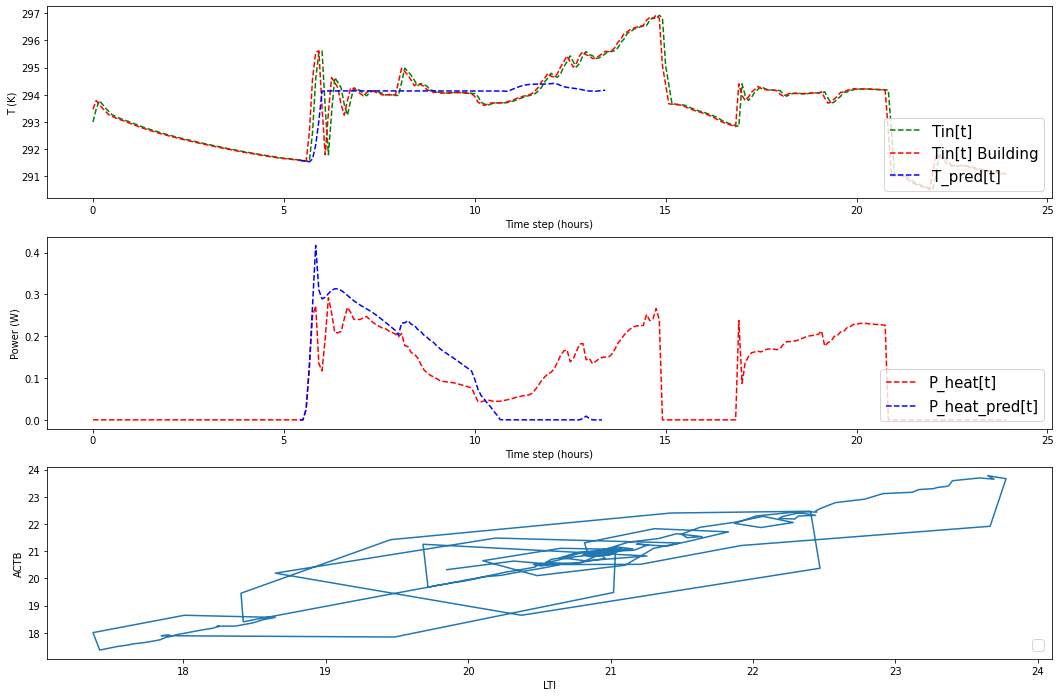

In [3]:
# Test plotting some variables 

# max_t: max range of values for the actual observations
# mpc_t_ind: index from which to start the MPC predictions
max_t = 288
mpc_t_ind=65
mpc_horizon = 97

k=plt.figure(figsize=(18,12),facecolor='white')
y1 = k.add_subplot(3,1,1)
y1.plot(time_data[:max_t], sim_data['_x', 't_indoor'][:max_t], 'g--', label="Tin[t]")
y1.plot(time_data[:max_t], historian['t_indoor_measured']+273.15, 'r--', label="Tin[t] Building")
mpc_data = sim_data.prediction(('_x', 't_indoor'), t_ind=mpc_t_ind)[0]  # there is only one element on this state variable.
y1.plot(time_data[mpc_t_ind:mpc_t_ind+mpc_horizon], mpc_data, 'b--', label="T_pred[t]")
y1.set_xlabel('Time step (hours)')
y1.set_ylabel('T (K)')
y1.legend(loc=4, prop={"size":15})

y2 = k.add_subplot(3,1,2)
y2.plot(time_data[:max_t], sim_data['_u', 'heating_power'][:max_t], 'r--', label="P_heat[t]")
mpc_data = sim_data.prediction(('_u', 'heating_power'), t_ind=mpc_t_ind)[0]
y2.plot(time_data[mpc_t_ind:mpc_t_ind+mpc_horizon-1], mpc_data, 'b--', label="P_heat_pred[t]")
y2.set_xlabel('Time step (hours)')
y2.set_ylabel('Power (W)')
y2.legend(loc=4, prop={"size":15})

# restructure the data a bit to make it easier to plot and 
# calculate some metrics.
x_list = []
y_list = []
for i in range(len(sim_data['_x', 't_indoor'][:max_t])):
    x_list.append(sim_data['_x', 't_indoor'][:max_t][i][0]-273.15)
    y_list.append(historian['t_indoor_measured'][i]+273.15-273.15)

y3 = k.add_subplot(3,1,3)
y3.plot(x_list, y_list)
y3.set_xlabel('LTI')
y3.set_ylabel('ACTB')
y3.legend(loc=4, prop={"size":15})

# Calculate R^2
mean_x = statistics.mean(x_list)
mean_y = statistics.mean(y_list)
print(f"mean x = {mean_x}; mean y = {mean_y}")

num = 0
denom_x = 0
denom_y = 0
for i in range(len(x_list)):
    x = x_list[i]
    y = y_list[i]

    num += (x - mean_x) * (y - mean_y)
    denom_x += (x - mean_x)**2 
    denom_y += (y - mean_y)**2

r = num / math.sqrt(denom_x * denom_y)
print(f"R is {r}; R^2 is {r**2}")

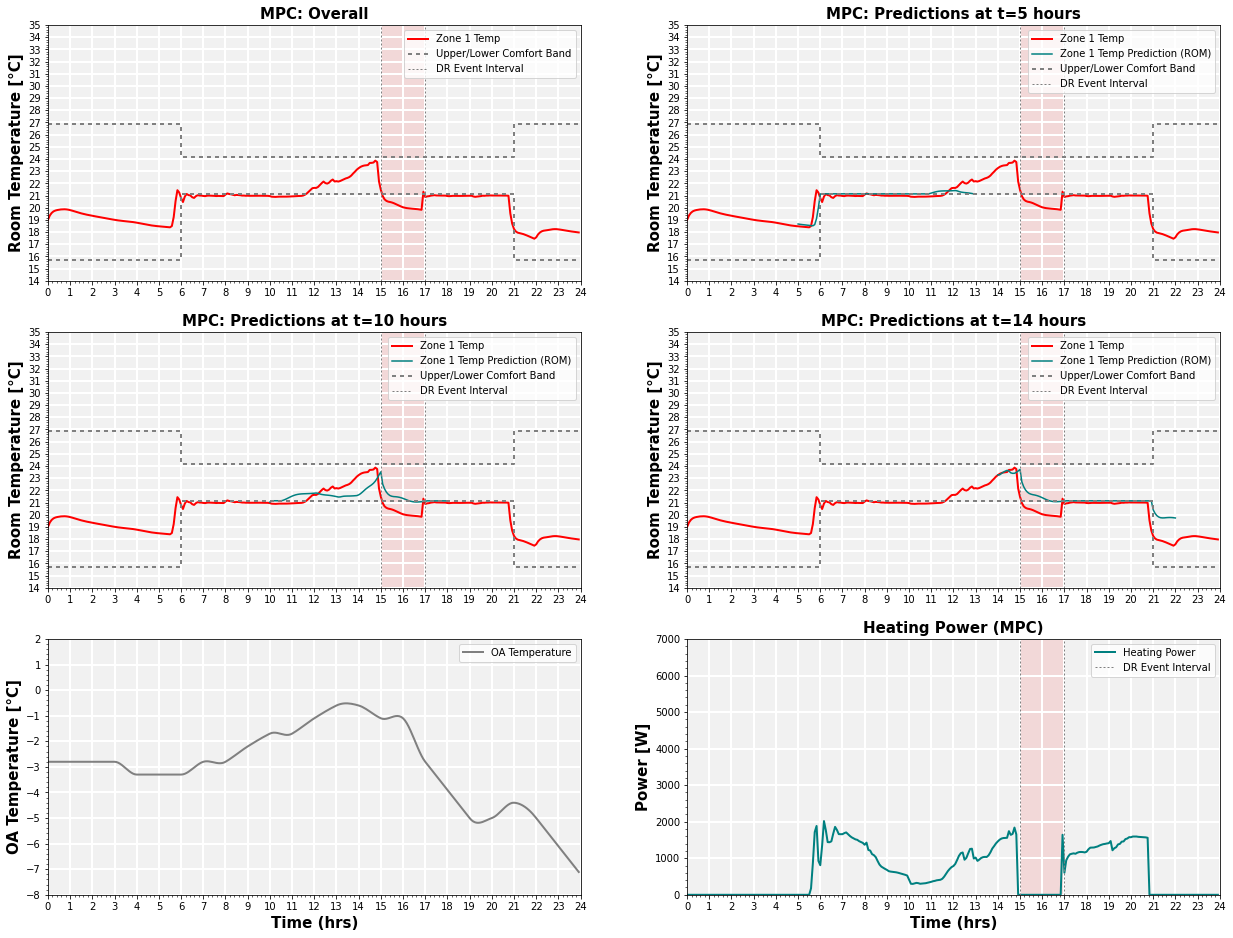

In [5]:
# configuration variables
max_t = 288
mpc_horizon = 97  # for _x and _tvp, _u is -1 (for some reason)

rect_1 = Polygon(((dr_start_1,8), (dr_start_1,40), (dr_end_1, 40),(dr_end_1,8)),
                 fc=(1,0,0,0.1), ec=(0,0,0,1), lw=0,linestyle='--')
rect_2 = Polygon(((dr_start_1,8), (dr_start_1,40), (dr_end_1, 40),(dr_end_1,8)),
                 fc=(1,0,0,0.1), ec=(0,0,0,1), lw=0,linestyle='--')
rect_3 = Polygon(((dr_start_1,8), (dr_start_1,40), (dr_end_1, 40),(dr_end_1,8)),
                 fc=(1,0,0,0.1), ec=(0,0,0,1), lw=0,linestyle='--')
rect_4 = Polygon(((dr_start_1,8), (dr_start_1,40), (dr_end_1, 40),(dr_end_1,8)),
                 fc=(1,0,0,0.1), ec=(0,0,0,1), lw=0,linestyle='--')
# rect_5 is not needed since it is temperature plot
rect_6 = Polygon(((dr_start_1,0), (dr_start_1,16000), (dr_end_1, 16000),(dr_end_1,0)),
                    fc=(1,0,0,0.1), ec=(0,0,0,1), lw=0,linestyle='--')

f=plt.figure(figsize=(21,16))
#f.suptitle('DQN Performance in Episode: '+str(episode),size=24, y =.95)
#filt_data["Hours"]= filt_data["Hours"]%24

up_limit=35
low_limit=14

x1 = f.add_subplot(3,2,1)

# use the values from do-mpc, which appear to be the planning model and not the execution model
# t_indoor = sim_data['_x', 't_indoor'][:max_t]-273
t_indoor = historian['t_indoor_predicted_after_kalman']
plot_demand = True

x1.plot(time_data[:max_t], t_indoor, label= "Zone 1 Temp",color="red", linewidth = 2)
x1.step(time_data[:max_t], sim_data['_tvp', 'TSetpoint_Lower'][:max_t]-273, where="post", label= "Upper/Lower Comfort Band", color="grey", linestyle='--', dashes=(2, 2), linewidth = 2)
x1.step(time_data[:max_t], sim_data['_tvp', 'TSetpoint_Upper'][:max_t]-273, where="post", color="grey", linestyle='--', dashes=(2, 2), linewidth = 2)
if plot_demand:
    x1.axvline(x = dr_start_1, color = 'grey',linestyle='--',linewidth = 1,dashes=(2, 2))
    x1.axvline(x = dr_end_1, color = 'grey',linestyle='--', label = 'DR Event Interval',linewidth = 1,dashes=(2, 2))
    x1.add_artist(rect_1)
x1.set_xlim([0, 24])
x1.set_ylim([low_limit, up_limit])
x1.yaxis.set_major_locator(ticker.MultipleLocator(1))
x1.xaxis.set_major_locator(ticker.MultipleLocator(1))
x1.minorticks_on()
x1.grid(which='major',linewidth=2,color='white')
x1.set_ylabel('Room Temperature [°C]',fontsize=15,fontweight='bold')
x1.legend(loc=4,prop={"size":15})
x1.set_facecolor("gainsboro")
x1.patch.set_alpha(0.4)
x1.set_title('MPC: Overall',fontweight='bold',fontsize=15)
x1.legend(loc=1)

t_mpc_hour = 5
t_mpc = t_mpc_hour * 12  # 5 minute intervals
x2 = f.add_subplot(3,2,2)
x2.plot(time_data[:max_t], t_indoor, label= "Zone 1 Temp",color="red", linewidth = 2)
x2.plot(time_data[t_mpc:t_mpc+mpc_horizon], sim_data.prediction(('_x', 't_indoor'), t_ind=t_mpc)[0]-273, label= "Zone 1 Temp Prediction (ROM)",color="teal", linewidth = 1.5)
x2.step(time_data[:max_t], sim_data['_tvp', 'TSetpoint_Lower'][:max_t]-273, where="post", label= "Upper/Lower Comfort Band", color="grey", linestyle='--', dashes=(2, 2), linewidth = 2)
x2.step(time_data[:max_t], sim_data['_tvp', 'TSetpoint_Upper'][:max_t]-273, where="post", color="grey", linestyle='--', dashes=(2, 2), linewidth = 2)
if plot_demand:
    x2.axvline(x = dr_start_1, color = 'grey',linestyle='--',linewidth = 1,dashes=(2, 2))
    x2.axvline(x = dr_end_1, color = 'grey',linestyle='--', label = 'DR Event Interval',linewidth = 1,dashes=(2, 2))
    x2.add_artist(rect_2)
x2.set_xlim([0, 24])
x2.set_ylim([low_limit, up_limit])
x2.yaxis.set_major_locator(ticker.MultipleLocator(1))
x2.xaxis.set_major_locator(ticker.MultipleLocator(1))
x2.minorticks_on()
x2.grid(which='major',linewidth=2,color='white')
x2.set_ylabel('Room Temperature [°C]',fontsize=15,fontweight='bold')
x2.legend(loc=4,prop={"size":15})
x2.set_facecolor("gainsboro")
x2.patch.set_alpha(0.4)
x2.set_title(f'MPC: Predictions at t={t_mpc_hour} hours',fontweight='bold',fontsize=15)
x2.legend(loc=1)

t_mpc_hour = 10
t_mpc = t_mpc_hour * 12  # 5 minute intervals
x3 = f.add_subplot(3,2,3)
x3.plot(time_data[:max_t], t_indoor, label= "Zone 1 Temp",color="red", linewidth = 2)
x3.plot(time_data[t_mpc:t_mpc+mpc_horizon], sim_data.prediction(('_x', 't_indoor'), t_ind=t_mpc)[0]-273, label= "Zone 1 Temp Prediction (ROM)",color="teal", linewidth = 1.5)
x3.step(time_data[:max_t], sim_data['_tvp', 'TSetpoint_Lower'][:max_t]-273, where="post", label= "Upper/Lower Comfort Band", color="grey", linestyle='--', dashes=(2, 2), linewidth = 2)
x3.step(time_data[:max_t], sim_data['_tvp', 'TSetpoint_Upper'][:max_t]-273, where="post", color="grey", linestyle='--', dashes=(2, 2), linewidth = 2)
if plot_demand:
    x3.axvline(x = dr_start_1, color = 'grey',linestyle='--',linewidth = 1,dashes=(2, 2))
    x3.axvline(x = dr_end_1, color = 'grey',linestyle='--', label = 'DR Event Interval',linewidth = 1,dashes=(2, 2))
    x3.add_artist(rect_3)
x3.set_xlim([0, 24])
x3.set_ylim([low_limit, up_limit])
x3.yaxis.set_major_locator(ticker.MultipleLocator(1))
x3.xaxis.set_major_locator(ticker.MultipleLocator(1))
x3.minorticks_on()
x3.grid(which='major',linewidth=2,color='white')
x3.set_ylabel('Room Temperature [°C]',fontsize=15,fontweight='bold')
x3.legend(loc=4,prop={"size":15})
x3.set_facecolor("gainsboro")
x3.patch.set_alpha(0.4)
x3.set_title(f'MPC: Predictions at t={t_mpc_hour} hours',fontweight='bold',fontsize=15)
x3.legend(loc=1)

t_mpc_hour = 14
t_mpc = t_mpc_hour * 12  # 5 minute intervals
x4 = f.add_subplot(3,2,4)
x4.plot(time_data[:max_t], t_indoor, label= "Zone 1 Temp",color="red", linewidth = 2)
x4.plot(time_data[t_mpc:t_mpc+mpc_horizon], sim_data.prediction(('_x', 't_indoor'), t_ind=t_mpc)[0]-273, label= "Zone 1 Temp Prediction (ROM)",color="teal", linewidth = 1.5)
x4.step(time_data[:max_t], sim_data['_tvp', 'TSetpoint_Lower'][:max_t]-273, where="post", label= "Upper/Lower Comfort Band", color="grey", linestyle='--', dashes=(2, 2), linewidth = 2)
x4.step(time_data[:max_t], sim_data['_tvp', 'TSetpoint_Upper'][:max_t]-273, where="post", color="grey", linestyle='--', dashes=(2, 2), linewidth = 2)
if plot_demand:
    x4.axvline(x = dr_start_1, color = 'grey',linestyle='--',linewidth = 1,dashes=(2, 2))
    x4.axvline(x = dr_end_1, color = 'grey',linestyle='--', label = 'DR Event Interval',linewidth = 1,dashes=(2, 2))
    x4.add_artist(rect_4)
x4.set_xlim([0, 24])
x4.set_ylim([low_limit, up_limit])
x4.yaxis.set_major_locator(ticker.MultipleLocator(1))
x4.xaxis.set_major_locator(ticker.MultipleLocator(1))
x4.minorticks_on()
x4.grid(which='major',linewidth=2,color='white')
x4.set_ylabel('Room Temperature [°C]',fontsize=15,fontweight='bold')
x4.legend(loc=4,prop={"size":15})
x4.set_facecolor("gainsboro")
x4.patch.set_alpha(0.4)
x4.set_title(f'MPC: Predictions at t={t_mpc_hour} hours',fontweight='bold',fontsize=15)
x4.legend(loc=1)

x5 = f.add_subplot(3,2,5)
x5.plot(time_data[:max_t], sim_data['_tvp', 'TDryBul'][:max_t], label= "OA Temperature",color="grey", linewidth = 2)
x5.set_xlim([0, 24])
x5.set_ylim([-8, 2])
x5.yaxis.set_major_locator(ticker.MultipleLocator(1))
x5.xaxis.set_major_locator(ticker.MultipleLocator(1))
x5.minorticks_on()
x5.grid(which='major', linewidth=2,color='white')
x5.set_ylabel('OA Temperature [°C]',fontsize=15,fontweight='bold')
x5.set_facecolor("gainsboro")
x5.set_xlabel('Time (hrs)',fontsize=15,fontweight='bold')
x5.patch.set_alpha(0.4)
x5.legend(loc=1)

#  \textbf{Zone} & \textbf{Cooling coil capacity (Watts)} & \textbf{Heating coil capacity (Watts)} & \textbf{Air flow ($m^{3}/s$)}\\ [0.5ex]
#  \hline\addlinespace[2pt]
#  Core & 14035 & 8607 & 0.45 \\
#  Perimeter 1 & 11316 & 6909 & 0.37\\
#  Perimeter 2 & 9873  & 6137 & 0.36\\
#  Perimeter 3 & 11587 & 7081 & 0.38\\
#  Perimeter 4 & 9691 & 6779 & 0.35\\
max_power = 6909
x6 = f.add_subplot(3,2,6)
x6.plot(time_data[:max_t], sim_data['_u', 'heating_power'][:max_t] * max_power, label= "Heating Power", color="teal", linewidth = 2)
x6.set_xlim([0, 24])
x6.yaxis.set_major_locator(ticker.MultipleLocator(1000))
x6.xaxis.set_major_locator(ticker.MultipleLocator(1))
x6.set_xlabel('Time in Hours',fontsize=15)
x6.minorticks_on()
x6.set_ylabel('Power [W]',fontsize=15,fontweight='bold')
x6.grid(which='major', linewidth=2,color='white')
x6.set_xlabel('Time (hrs)',fontsize=15,fontweight='bold')
if plot_demand:
    x6.axvline(x = dr_start_1, color = 'grey',linestyle='--',linewidth = 1,dashes=(2, 2))
    x6.axvline(x = dr_end_1, color = 'grey',linestyle='--', label = 'DR Event Interval',linewidth = 1,dashes=(2, 2))
    x6.add_artist(rect_6)
x6.set_title("Heating Power (MPC)",fontweight='bold',fontsize=15)
x6.set_facecolor("gainsboro")
x6.patch.set_alpha(0.4)
x6.set_ylim([0, 7000])
x6.legend(loc=1)

z=f'{results_folder}/MPC_Performance_1.jpg'

plt.savefig(z,dpi=400)